# Physics 404/604

## Computational Physics (Spring 2018)

## BPB-250, Mon./Wed. 2:30-3:45 pm

| Instructor | Prof. Zhaohuan Zhu                 |
| ---------- | :--------------------------------- |
| Email      | zhaohuan.zhu@unlv.edu              |
| Website    | http://www.physics.unlv.edu/~zhzhu |
| Office     | BPB 245                            |

# Oscillator

A mass m attached to a string that exerts a restoring force (F) toward the origin. Then equation of motion
is simply 
\begin{equation}
m\frac{d^2 x}{dt^2}=F(x)
\end{equation}
If there is no external force (only the force from the string or the friction force is present), this is called
a Harmonic Oscillator. If the friction is zero, it is called a Simple Harmonic Oscillator. 

## Simple Harmonic Oscillator

If the force from the string follows the Hooke's Law (F(x)=-k x), where x is with respect to the stationary position, we can solve this equation analytically. 
\begin{equation}
\frac{d^2 x}{dt^2}=-\frac{k}{m}x
\end{equation}

For second order ODE, we need to constraints ($x_{0}$ and $v_{0}$). The solution can be
written as
\begin{equation}
x(t)=Acos(\omega_{0}t)+Bsin(\omega_{0}t)
\end{equation}
or
\begin{equation}
x(t)=Asin(\omega_{0}t+\phi)
\end{equation}
where $\omega_{0}=\sqrt{k/m}$ and $A^2=x_{0}^2+(v_{0}/\omega_{0})^2$ and
$\phi=tan^{-1}(x_{0}\omega_{0}/v_{0})$. So the period is 2$\pi \sqrt{m/k}$

## Damped Harmonic Oscillator

If the friction is non-zero, the equation becomes
\begin{equation}
\frac{d^2 x}{dt^2}=-\frac{k}{m}x-c\dot{x(t)}
\end{equation}
We will solve this equation with a more general method: characteristic equation.
Assume $x(t)=e^{rt}$, and then $\dot{x(t)}=re^{rt}$ and $d^2x(t)/dt^2=r^2e^{rt}$. If we put these terms
in the equation, we have
\begin{equation}
r^2+cr+K=0
\end{equation}
where $K=\frac{k}{m}$. So
\begin{equation}
r=\frac{-c\pm\sqrt{c^2-4K}}{2}
\end{equation}
If $(c^2-4K)>0$, it is called overdamped. If it is equal to 0, it is called critically damped.
If it is smaller than 0, it is called underdamped. 

For underdamped system, the solution is
\begin{equation}
x(t)=Ae^{\frac{-c+i\sqrt\alpha}{2}t}+Be^{\frac{-c-i\sqrt\alpha}{2}t}
\end{equation}
were $\alpha=4K-c^2$
or
\begin{equation}
x(t)=e^{-ct/2}(Acos(\omega_{0}t)+Bsin(\omega_{0}t))
\end{equation}
where  $\omega_{0}=\frac{1}{2}\sqrt{4K-c^2}$.
We can also write the solution as
\begin{equation}
x(t)=Ae^{-ct/2}sin(\omega_{0}t+\phi)
\end{equation}

## Nonlinear Oscillator

However, this is as far as we can get analytically. If the force is nonlinear (e.g. -kx(1-$\alpha$x) or -k$x^{p-1}$), we have
to solve it numerically. 

To solve it with RK method
\begin{equation}
\frac{dx}{dt}=v\\
\frac{dv}{dt}=F
\end{equation}

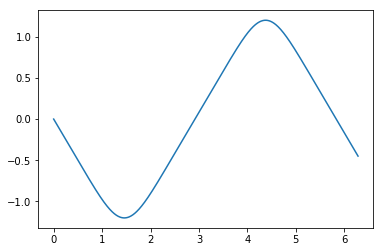

In [6]:
# Let's first try linear force  Fx=-x, then try Fx=, -x**3, -x**5, ..., -x**11

""" From "COMPUTATIONAL PHYSICS", 3rd Ed, Enlarged Python eTextBook  
    by RH Landau, MJ Paez, and CC Bordeianu
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

# rk4.py 4th order Runge Kutta
		 
import matplotlib.pylab as p
import numpy as np

#   Initialization
a = 0.
b = 6.2832
n = 1000                                         
ydumb = np.zeros((2), float);    y = np.zeros((2), float)
fReturn = np.zeros((2), float);  k1 = np.zeros((2), float)
k2 = np.zeros((2), float);       k3 = np.zeros((2), float) 
k4 = np.zeros((2), float)
y[0] = 0.;   y[1] = -1.
t = a;       h = (b-a)/n;
xp=np.array([0.0])
yp=np.array([y[0]])

def f( t, y):                                           # Force function 
    fReturn[0] = y[1] # finish this line                                            
    fReturn[1] = -y[0]**5 # finish this line      
    return fReturn

def rk4(t,h,n):                 
    k1 = [0]*(n)
    k2 = [0]*(n)
    k3 = [0]*(n)
    k4 = [0]*(n)
    fR = [0]*(n)
    ydumb = [0]*(n)
    fR = f(t, y)                                            # Returns RHS's  
    for i in range(0, n):
        k1[i] = h*fR[i]                             
    for i in range(0, n):
        ydumb[i] = y[i] + k1[i]/2. 
    k2 = h*f(t+h/2., ydumb) 
    for i in range(0, n):
        ydumb[i] = y[i] + k2[i]/2. 
    k3 = h*f(t+h/2., ydumb)
    for i in range(0, n):
        ydumb[i] = y[i] + k3[i] 
    k4 = h*f(t+h, ydumb) 
    for i in range(0, 2):
        y[i] = y[i] + (k1[i] + 2.*(k2[i] + k3[i]) + k4[i])/6.
    return y    

while (t < b):                                              # Time loop
    if ((t + h) > b):
        h = b - t                                           # Last step
    y = rk4(t,h,2)
    t = t + h
    xp=np.append(xp, t)
    yp=np.append(yp,y[0])
    
p.plot(xp,yp)
p.show()

# Fourier Analysis

Suppose we are measuring the position of the oscillator above and get a series of data (time and position). Now we want to do data analysis to derive the period and amplitude of the oscillation. The data may be periodic but not necessarily harmonic (e.g. p=10 case above). 

A periodic function (y(t+T)=y(t)) can be expanded as a series of harmonic functions with frequencies that are multiples of the true frequency:
\begin{equation}
y(t)=\frac{a_{0}}{2}+\sum_{n=1}^{\infty}(a_{n}cos\, n\omega t+b_{n}sin\, n\omega t)
\end{equation}
where $\omega=\frac{2\pi}{T}$.
Then intensity of power at each frequency is $a^2_{n}+b^2_{n}$.

The coefficients $a_{n}$ and $b_{n}$ are
\begin{equation}
a_{n}=\frac{2}{T}\int_{0}^T dt cos\,n\omega t \, y(t)
\end{equation}
and
\begin{equation}
b_{n}=\frac{2}{T}\int_{0}^T dt sin\,n\omega t \, y(t)
\end{equation}

* $a_{0}$ is twice the average value of y
* For an odd function (y(-t)=-y(t)), all $a_{n}$ are 0.
* For an even function (y(-t)=y(t)), all $b_{n}$ are 0.

## Two examples:

### The sawtooth function

\begin{eqnarray}
y(t)&=\frac{t}{T/2},\quad for\, 0<t<\frac{T}{2}\,,\\
y(t)&=\frac{t-T}{T/2},\quad for\, \frac{T}{2}<t<T
\end{eqnarray}

Since it is an odd function, all $a_{n}$ are 0, and
\begin{equation}
b_{n}=\frac{2}{T}\int_{-T/2}^{T/2} dt sin\,n\omega t \, \frac{t}{T/2}=\frac{2}{n\pi}(-1)^{n+1}
\end{equation}
So we have
\begin{equation}
y(t)=\frac{2}{\pi}\left[sin \omega t-\frac{1}{2}sin 2\omega t+\frac{1}{3}sin 3\omega t -...\right]
\end{equation}

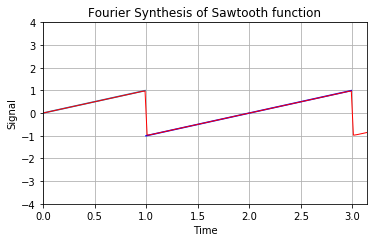

In [12]:
""" Author: Oscar Restrepo, From "COMPUTATIONAL PHYSICS", 3rd Ed, Enlarged Python  
   eTextBook by RH Landau, MJ Paez, and CC Bordeianu. 
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

" FourierMatplot.py: Fourier synthesis  sawtooth + interactive slider"

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from pylab import *

M = 4                                
T = 2.                                                    # Period 

numwaves =  1000
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.15, bottom=0.25)         # L & B margins
t = np.arange(0.0, pi, 0.01)               
t1 = np.arange(0.0,T/2,0.01)               
t2 = t[100:300]                               
f1 = t1                                 
f2 = t2-T                                  
s = 0 
plot(t1,f1)                                 
plot(t2,f2,color='b')           

def Four(M,T,t):         # M = number waves, T = period, t = time
    sumy = 0                                            
    om = 2.*pi/T                                    # Omega = 2pi/T
    fac = 1
    for m in range(1,M):         
        fac = ((-1)**(m+1))/m        # Finish this line, and try different numwaves at the top
        sumy += fac*sin(m*om*t)                       
    sumy = (2.0/pi)*sumy                           # Common factor
    return sumy

s = Four(M,T,t)                                    # Initial plot   
l, = plt.plot(t,s, lw=1, color='red')
plt.axis([0, pi, -4.0, 4.0])             # minx, maxx, miny, maxy

xlabel('Time')                                        
ylabel('Signal')                                      
title('Fourier Synthesis of Sawtooth function')
grid(True)               


# Previous: value of the slider (float) assigned to snumwaves

def hzfunc():     
    hzdict = Four(int(numwaves),T,t)
    ydata = hzdict
    l.set_ydata(ydata)
    plt.draw()

hzfunc()

plt.show()

### The half-wave function

\begin{eqnarray}
y(t)&=&sin \omega t,\quad for\, 0<t<\frac{T}{2}\,,\\
y(t)&=&0,\quad for\, \frac{T}{2}<t<T
\end{eqnarray}

So
\begin{equation}
a_{n}=\frac{-2}{\pi(n^2-1)},\quad n\,even\, or\,0
\end{equation}
and $b_{1}=1/2$, and all other $a_{n}$ and $b_{n}$ are zero.


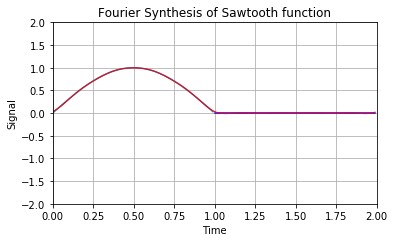

In [4]:
""" Author: Oscar Restrepo, From "COMPUTATIONAL PHYSICS", 3rd Ed, Enlarged Python  
   eTextBook by RH Landau, MJ Paez, and CC Bordeianu. 
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

" FourierMatplot.py: Fourier synthesis  sawtooth + interactive slider"

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from pylab import *

M = 4                                 
T = 2.                                                    # Period 

numwaves =  10
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.15, bottom=0.25)         # L & B margins
t = np.arange(0.0, T, 0.01)               
t1 = np.arange(0.0,T/2,0.01)               
t2 = t[100:300]  
om = 2.*pi/T 
f1 = sin(om*t1)                                 
f2 = t2*0.                                  
s = 0 
plot(t1,f1)                                 
plot(t2,f2,color='b')           

def Four(M,T,t):         # M = number waves, T = period, t = time
    om = 2.*pi/T 
    sumy = 1./2.*sin(om*t)+1./pi                                            
    for m in np.arange(2,M,2):         # M variable selected with slider
        fac = -2./pi/(m*m-1)
        sumy += fac* cos(m*om*t)                          
    return sumy

s = Four(M,T,t)                                    # Initial plot   
l, = plt.plot(t,s, lw=1, color='red')
plt.axis([0, T, -2.0, 2.0])             # minx, maxx, miny, maxy

xlabel('Time')                                        
ylabel('Signal')                                      
title('Fourier Synthesis of Sawtooth function')
grid(True)               


# Previous: value of the slider (float) assigned to snumwaves

def hzfunc():     
    hzdict = Four(int(numwaves),T,t)
    ydata = hzdict
    l.set_ydata(ydata)
    plt.draw()

hzfunc()

plt.show()

## Fourier Transforms:

If the function is non-periodic, we can imagine a system with a continuum of fundamental frequencies.
\begin{equation}
y(t)=\int_{-\infty}^{\infty}d\omega Y(\omega)\frac{e^{i\omega t}}{\sqrt{2\pi}}
\end{equation}
Notice that $\omega$ is real while $Y(\omega)$ is a complex function. $Y(\omega)$ is called the Fourier transform of y(t). We thus have
\begin{equation}
Y(\omega)=\int_{-\infty}^{\infty}dt y(t)\frac{e^{-i\omega t}}{\sqrt{2\pi}}
\end{equation}
If we substitute the transform into the inverse transform, we have
\begin{equation}
Y(\omega)=\int_{-\infty}^{\infty}dt\frac{e^{-i\omega t}}{\sqrt{2\pi}}\int_{-\infty}^{\infty}d\omega' Y(\omega')\frac{e^{i\omega' t}}{\sqrt{2\pi}}
\end{equation}
And we have Dirac delta function identity:
\begin{equation}
\int_{-\infty}^{\infty}dt e^{i(\omega'-\omega) t}=2\pi\delta(\omega'-\omega)
\end{equation}

## The Discrete Fourier Transform:

In practice, we only have a finite number measurements. We can use these values to do Fourier transform,
and construct the signal for any value of the time. In this way, DFT is a technique for interpolating, 
compressing, and extrapolating the signal. 

We assume the signal y(t) is sampled at (N+1) discrete times with a constant spacing $\Delta$t=h between them. 
\begin{eqnarray}
y_{k}&=&y(t_{k}),\quad k=0,1,2,...,N\\
t_{k}&=&k h,\quad h=\Delta t
\end{eqnarray}
The total time to sample the data is thus T=Nh. When we choose the period T to sample the data, we implicitly assume that y(t+T)=y(t), and thus $y_{0}=y_{N}$.

The time interval T is the largest time over which we measure y(t). It determines the lowest frequency 
\begin{equation}
\omega_{1}=\frac{2\pi}{T}
\end{equation}
The full range of frequencies is thus
\begin{equation}
\omega_{n}=n\omega_{1}\quad n=0,1,...,N
\end{equation}
n=0 is the part of the siginal that does not oscillate. 

DFT follows from two approximations. First we evaluate the integral from time 0 to time T, instead of $-\infty$ to $\infty$. Second, the trapezoid rule is used for the integration
\begin{eqnarray}
Y(\omega_{n})&=&\int_{-\infty}^{\infty}dt y(t)\frac{e^{-i\omega t}}{\sqrt{2\pi}}\sim\int_{0}^{T}dt y(t)\frac{e^{-i\omega_{n}t}}{\sqrt{2\pi}}\\
&=&\sum_{k=1}^{N}h y(t_{k})\frac{e^{-i\omega_{n}t_{k}}}{\sqrt{2\pi}}=h \sum_{k=1}^{N} y_{k}\frac{e^{-i n 2\pi k /N }}{\sqrt{2\pi}}
\end{eqnarray}
Sometimes, we devide this by h to get $Y_{n}$ ($Y_{n}=\frac{1}{h}Y(\omega_{n})$).

With $d\omega=2\pi/Nh$, we write
\begin{equation}
y(t)=\int_{-\infty}^{\infty}d\omega Y(\omega)\frac{e^{i\omega t}}{\sqrt{2\pi}}
\end{equation}
as
\begin{equation}
y(t)=\sum_{n=1}^{N}\frac{2\pi}{Nh}\frac{e^{i\omega_{n} t}}{\sqrt{2\pi}}Y(\omega_{n})
\end{equation}

Computationally, a good way to calculate DFT is
\begin{eqnarray}
Y_{n}&=&\frac{1}{\sqrt{2\pi}}\sum_{k=1}^{N} y_{k}Z^{nk}\\
y_{k}&=&\frac{\sqrt{2\pi}}{N}\sum_{n=1}^{N} Z^{-nk} Y_{n}\quad Z=e^{-2\pi i/N}
\end{eqnarray}



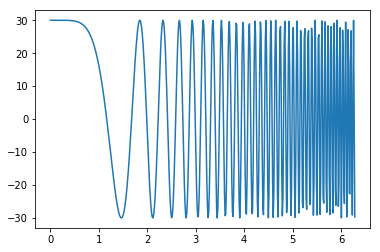

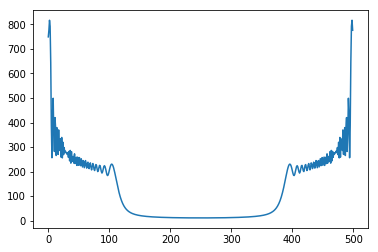

In [16]:
""" From "COMPUTATIONAL PHYSICS", 3rd Ed, Enlarged Python eTextBook  
    by RH Landau, MJ Paez, and CC Bordeianu
    Copyright Wiley-VCH Verlag GmbH & Co. KGaA, Berlin;  Copyright R Landau,
    Oregon State Unv, MJ Paez, Univ Antioquia, C Bordeianu, Univ Bucharest, 2015.
    Support by National Science Foundation"""

# DFTcomplex.py:  Discrete Fourier Transform with built in complex
from numpy import *
import matplotlib.pyplot as plt
import cmath                                            # complex math
    
    
N = 500;                  Np = N                           
signal = zeros( (N+1), float )     
twopi  = 2.*pi;       sq2pi = 1./sqrt(twopi);         h = twopi/N
dftz   = zeros( (Np), complex )                  # Complex elements
xa = zeros( (N+1), float )   
nplot = zeros( N, float )   
fplot = zeros( N, float ) 

def f(signal):                                                  # Signal
    step = twopi/N;        
    x = 0. 
    for i in range(0, N+1):
        signal[i] = 30*cos(x*x*x)
        xa[i] = x                      # Plot
        x += step
        
      
def fourier(dftz):                                              # DFT
    for n in range(0, Np):              
      zsum = complex(0.0, 0.0)                
      for  k in range(0, N):                              
          zexpo = complex(0, twopi*k*n/N)           # Complex exponent
          zsum += (e**-zexpo)*signal[k]         # finish this line
      dftz[n] = zsum * sq2pi      
      nplot[n] = n
      fplot[n] = sqrt(dftz[n].imag*dftz[n].imag+dftz[n].real*dftz[n].real)

f(signal);       
fourier(dftz)              # Call signal, transform
plt.plot(xa,signal)
plt.show()
plt.plot(nplot,fplot)
plt.show()


In [17]:
print(fplot)

[749.34818016 776.17093098 817.11362777 792.77631908 644.47760288
 387.13023059 256.44636884 435.27456495 499.03745146 353.96572901
 281.94705235 420.23162386 378.10645791 265.5830671  379.49531014
 344.99545214 270.05944759 369.86378571 285.97388611 307.91410089
 333.94600626 258.8219671  339.23392183 255.8446516  319.7145696
 269.00726311 298.04650055 277.15098161 283.61641497 277.02706659
 277.34995448 270.1377117  277.73579719 258.04303379 282.35811
 243.62592302 286.32020431 234.51456874 281.46226963 241.27255151
 261.19940281 261.79498247 234.38502117 272.39014467 232.69330771
 251.92087684 258.49161378 225.11033358 258.93842986 243.80412182
 225.81326124 257.26637337 236.51849202 224.01495004 252.642851
 236.13304129 218.85416093 244.96183529 240.96719764 215.75693767
 230.81352506 244.94126838 223.76085496 214.10639871 235.06932313
 238.31270415 216.7853422  212.20210251 231.06391087 235.59832156
 217.79348368 206.93836978 219.84062175 232.86505635 226.37733237
 209.15058401 20

## Fun stuff:

If you want to know how to do Fourier transfer mechanically in old days:
http://www.engineerguy.com/fourier/


## Homework:

Highly nonlinear oscillator: 

Recall the numerical solution for oscillations of a spring with power p = 12 (use F=-0.01\*y[0]\**11). Decompose the solution into a Fourier series and determine the number of higher harmonics that contribute at least 10%; for example, determine the n for which |bn /b1 | < 0.1. Check that resuming the components reproduces the signal.
(Landau 289)

Warning: please only sample the data within one period

Landau, Rubin H., Manuel Páez, Cristian Bordeianu. Computational Physics: Problem Solving with Python, 3rd Edition. Wiley-Blackwell, 2015-07-15. VitalBook file.

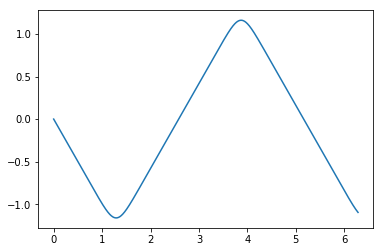

In [2]:
# use F=-y[0]**11 instead

import matplotlib.pylab as p
import numpy as np

#   Initialization
a = 0.
b = 6.2832
n = 1000                                         
ydumb = np.zeros((2), float);    y = np.zeros((2), float)
fReturn = np.zeros((2), float);  k1 = np.zeros((2), float)
k2 = np.zeros((2), float);       k3 = np.zeros((2), float) 
k4 = np.zeros((2), float)
y[0] = 0.;   y[1] = -1.
t = a;       h = (b-a)/n;
xp=np.array([0.0])
yp=np.array([y[0]])

def f( t, y):                                           # Force function 
    fReturn[0] = y[1]                                         
    fReturn[1] = -y[0]**11     
    return fReturn

def rk4(t,h,n):                 
    k1 = [0]*(n)
    k2 = [0]*(n)
    k3 = [0]*(n)
    k4 = [0]*(n)
    fR = [0]*(n)
    ydumb = [0]*(n)
    fR = f(t, y)                                            # Returns RHS's  
    for i in range(0, n):
        k1[i] = h*fR[i]                             
    for i in range(0, n):
        ydumb[i] = y[i] + k1[i]/2. 
    k2 = h*f(t+h/2., ydumb) 
    for i in range(0, n):
        ydumb[i] = y[i] + k2[i]/2. 
    k3 = h*f(t+h/2., ydumb)
    for i in range(0, n):
        ydumb[i] = y[i] + k3[i] 
    k4 = h*f(t+h, ydumb) 
    for i in range(0, 2):
        y[i] = y[i] + (k1[i] + 2.*(k2[i] + k3[i]) + k4[i])/6.
    return y    

while (t < b):                                              # Time loop
    if ((t + h) > b):
        h = b - t                                           # Last step
    y = rk4(t,h,2)
    t = t + h
    xp=np.append(xp, t)
    yp=np.append(yp,y[0])
    
p.plot(xp,yp)
p.show()